# SI on a slope

This notebook takes a single output of the 2D_SI_DNS dedalus run. Makes descriptive plots and analyzes energetics.

Author: Jacob Wenegrat

In [144]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from pylab import *
import scipy.integrate as integrate
#from cmocean import cm as cmo
import matplotlib.gridspec as gridspec
import matplotlib.ticker 
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.special as special
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

## Load variables

In [604]:
#%% Pick the filename and path
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/snapshots_0p10.h5' #0.1 slope
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05_LONG.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_5e-7_0p42/snapshots/snapshots_5e-7_0p42.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p0225/snapshots/snapshots_1e-5_0p0225.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LONG.h5' #Ruan case F
# filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_Q1D.h5' #Ruan case F

# filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LONG.h5' #Ruan case F
# filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LOWV.h5' #Ruan case F

# filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005.h5' #Ruan case A
# filename =  '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p01/snapshots/snapshots_1e-6_0p01.h5'
# filename =  '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p1/snapshots/snapshots_1e-6_0p1.h5'

# filename =  '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/downslope/downslope_s2.h5' # oscillating current


visc = 5e-5
visc = 1e-4

f = h5py.File(filename, 'r')

# Get the data
data = list(f['tasks'])

# Basic parameters
N = f['tasks']['N'][0,0,0] #Interior stratification (background)
tht = f['tasks']['tht'] # Slope angle


# Load variables in physical space
u = f['tasks']['u'] # Cross-slope direction
v = f['tasks']['v'] # Along-slope direction
w = f['tasks']['w'] # Slope-normal direction
b = f['tasks']['b'] # Perturbation buoyancy

qa = f['tasks']['PVa']
q = f['tasks']['PV']
wq = f['tasks']['wq']
# Energy terms XXX - Need to go clean these up in Dedalus
gsp = f['tasks']['GSP']
gspr = f['tasks']['GSProtated']
vspu = f['tasks']['VSPu']
vspv = f['tasks']['VSPv']
vsp = vspu[:,:,:]+vspv[:,:,:]
lspu = f['tasks']['LSPu']
lspv = f['tasks']['LSPv']
lsp = lspu[:,:,:] + lspv[:,:,:]
diss = f['tasks']['Diss']
vbf = f['tasks']['VBF']
# vbfsg= f['tasks']['VBFsg']
vbfr = f['tasks']['VBFr']
hbfr = f['tasks']['HBFrotated']
hbfr = hbfr*np.sin(tht[0,0,0])
vbfrot = f['tasks']['VBFrotated']
sp = f['tasks']['SP']
EKE = f['tasks']['EKE']

# SPECTRAL QUANTITIES
ws = f['tasks']['wcs']
bs = f['tasks']['bs']
vs = f['tasks']['vcs']


# Domain parameters
x = u.dims[1][0][:]
z = u.dims[2][0][:]
time = u.dims[0][0][:]
kx = f['scales/kx'][:]/(2*np.pi) # Inverse wavelengths in cross-front direction

In [146]:
time = u.dims[0][0][:]


In [ ]:
ti = np.where((time/86400>7.5) & (time/86400<15))[0]

plt.plot(np.mean(np.mean(vbfrot[ti,:,:], axis=1), axis=0), z, label='$\langle w^\prime b^\prime\\rangle$')

plt.plot(np.mean(np.mean(vbfrot[ti,:,:]/(1+N**2*tht[0,0,0]**2/1e-8), axis=1), axis=0), z, label='$\langle w^\prime b^\prime\\rangle$')
plt.plot(np.mean(np.mean(vbfr[ti,:,:], axis=1), axis=0), z, label='$\langle \hat{w}^\prime b^\prime\\rangle$')
plt.legend()
print(integrate.trapz(np.mean(np.mean(vbfrot[ti,:,:], axis=1), axis=0), x=z))
print(integrate.trapz(np.mean(np.mean(vbfr[ti,:,:], axis=1), axis=0), x=z))
print(integrate.trapz(np.mean(np.mean(sp[ti,:,:], axis=1), axis=0), x=z))

In [605]:
# Calculated quantities
# XXX- Go through and check this all carefully
va = np.mean(v, axis=1)

qm = np.mean(q, axis=1) 
bm = np.mean(b, axis=1)
bxc = np.gradient(b, axis=1)/np.gradient(x[np.newaxis, :,np.newaxis], axis=1)*np.cos(tht)- np.gradient(b, axis=-1)/np.gradient(z[np.newaxis, np.newaxis,:], axis=-1)*np.sin(tht) #f['tasks']['bxs']
bx = np.gradient(b, axis=1)/np.gradient(x[np.newaxis, :, np.newaxis], axis=1)
bxcm = np.mean(bxc, axis=1)
bxm = np.mean(bx, axis=1)

bzr = np.gradient(bm, axis=-1)/np.gradient(z)*np.cos(tht[0,0,0]) + bxcm*np.sin(tht[0,0,0]) + N**2

um = np.mean(u, axis=1)
vm = np.mean(v, axis=1)
up = u - um[:,np.newaxis,:]
vp = v - vm[:,np.newaxis,:]

uz = np.gradient(um, axis=-1)/np.gradient(z)
vz = np.gradient(vm, axis=-1)/np.gradient(z) 
wz = np.gradient(np.mean(w, axis=1), axis=-1)/np.gradient(z)
zm = z-z[-1]
qt = np.transpose(np.transpose(np.gradient(qm, axis=0))/np.gradient(time))
qta = np.gradient(qa[:,0,0])/np.gradient(time)
bb = x[np.newaxis,:,np.newaxis]*N**2*np.sin(tht[0,0,0]) + N**2*np.cos(tht[0,0,0])*z[np.newaxis, np.newaxis,:]
bf = b + bb
bz = np.gradient(bm, axis=-1)/np.gradient(z) + N**2
bz_prime = np.gradient(bm, axis=-1)/np.gradient(z)
Ri = bz/(uz**2 + vz**2)

gsps = 2*np.real(-np.conj(vs)*ws*bxcm[:,np.newaxis,:]/1e-4)
vbfs = 2*np.real(np.conj(ws)*bs)

#zetaprimebprime = np.mean((bf - np.mean(bf,axis=1))*(np.gradient(v, axis=1)/np.gradient(x)), axis=1)
uz = np.gradient(u, axis=-1)/np.gradient(z)
vz = np.gradient(v, axis=-1)/np.gradient(z)
EKEt = np.gradient(EKE[:,0,:], axis=0)/np.gradient(time[:,np.newaxis], axis=0)

MKE = 0.5*(um**2 + (vm)**2)
MKEt = np.gradient(MKE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

MAPE = 0.5*np.mean(b[:,:,:]**2, axis=1)/N**2
MAPEt = np.gradient(MAPE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

# SPECTRAL
wbs = 2*np.real(np.conj(ws)*bs)
wvs = 2*np.real(np.conj(ws)*vs)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
wbs = 2*np.real(np.conj(ws)*bs)
wvs = 2*np.real(np.conj(ws)*vs)

In [ ]:
MKE = np.mean(0.5*(u[:,:,:]**2 + (v[:,:,:])**2 + w[:,:,:]**2), axis=1)
# MKE = 0.5*(um**2 + (vm)**2)

MKEt = np.gradient(MKE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

# MAPE = 0.5*np.mean(b[:,:,:]**2, axis=1)/N**2
# MAPEt = np.gradient(MAPE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

MKEMPE = um[:,:]*bm[:,:]*np.sin(tht[0,0,0])

## Estimate bottom stress and Ekman transport

The bottom stress is needed to calculate the cross-slope Ekman transport. 
There are several ways to calculate this. The first is directly, given that we resolve the viscous layer ($\delta_v = \nu/u^*$).
\begin{equation}
\tau_y = \rho \nu \frac{\partial v}{\partial z}
\end{equation}
where $\nu$ is the subgrid viscosity.

The other way (which would in some sense be preferable for observational purposes, would be using a drag coefficient:
\begin{equation}
\tau_y = \rho C_d \sqrt{u^2 + v^2}v
\end{equation}
This appears to work reasonably well, however it has to be evaluated on the order of meters above the bottom. Not sure how this is supposed to actually be evaluated (ie. is there a principled way to pick the depth?).

Using these the cross-slope Ekman transport is given by,

\begin{equation}
B_{Ek} = \frac{\tau_y}{\rho_o f} N^2 \sin{\theta}
\end{equation}

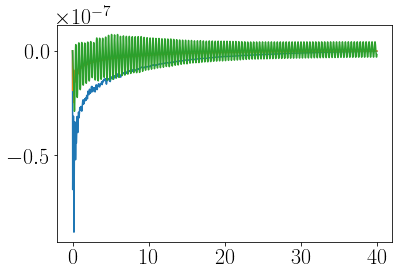

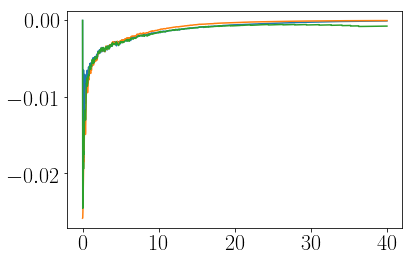

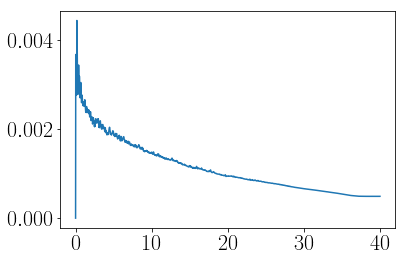

In [606]:

uss = visc*np.sqrt(np.mean(uz[:,:,0], axis=1)**2 + np.mean(vz[:,:,0], axis=1)**2) # This is u*^2...need to confirm this definition
uss = visc*np.sqrt(np.mean(uz[:,:,0]**2 + vz[:,:,0]**2, axis=1))
us = np.sqrt(uss)
usm = np.mean(us)
delv = visc/usm

tauy = -1035*visc*np.mean(vz[:,:,0], axis=1) #Note that 1e-4 is the viscosity for the DNS
taux = -1035*visc*np.mean(uz[:,:,0], axis=1) #Note that 1e-4 is the viscosity for the DNS

zind = 16
cd = 2.5e-3
tauya = -1035*cd*np.mean(np.sqrt(u[:,:,zind]**2 + (v[:,:,zind]+0.1)**2)*(v[:,:,zind]+0.1), axis=1)
#tauy= tauya
# This plot is to confirm that the viscous layer is being resolved
#plt.figure()
#plt.plot((z[1:]-z[:-1])/delv, 0.5*(z[1:] + z[:-1]), marker='x')

# calculate bottom velocity at 50*delv
nt = time.size
ub = np.zeros((nt,))
vb = np.zeros((nt,))
for i in range(1,nt):
    tempind = np.where(z>50*visc/us[i])[0][0]
    ub[i] = um[i,tempind]
    vb[i] = vm[i,tempind]+0.1
# Can calculate the Ekman transport using bottom stress:
Bek = tauy/(1030*1e-4)*N**2*np.sin(tht[:,0,0])
Beka = tauy/(1030*1e-4*(1+N**2*np.sin(tht[0,0,0])**2/1e-8))*N**2*np.sin(tht[:,0,0])

# Alternately calculate the actual cross-slope buoyancy transport
Ubar = integrate.trapz(um,x=zm, axis=-1 )
BekD = Ubar*N**2*np.sin(tht[:,0,0])
#Bek = Beka
# Compare three estimates of stress
plt.plot(time/86400, Bek)
plt.plot(time/86400, Beka)
plt.plot(time/86400, BekD)

plt.figure()
plt.plot(time/86400, tauy)
plt.plot(time/86400, tauya)
plt.plot(time/86400, -1030*cd*np.sqrt(ub**2 + vb**2)*vb)

plt.figure()
plt.plot(time/86400, us)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


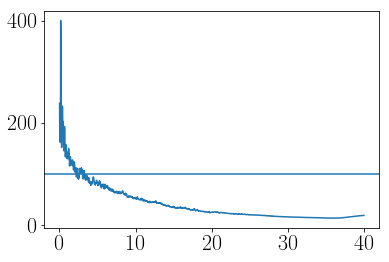

In [607]:
# Look at Slope Monin Obukhov Length as in Ruan et al. 2019

Lo = us**3/(0.4*-Beka)
zs = visc/us
plt.plot(time/86400, Lo/zs)
plt.axhline(100) # Approximate relaminarization point

In [ ]:
plt.plot(time*1e-4, Beka)
# plt.plot(time*1e-4, tauy/(1+S))

S = N**2*np.tan(tht[0,0,0])**2/1e-8
print(S)
tscale = (1/((S)**2*1e-4*np.cos(tht[0,0,0]))) #MR91
print(tscale/86400)
cd = 5e-3
d = cd*N/1e-4 #BL01
gamma =  (1 + np.sqrt(1+4*(1-S/(1+S))**(-1)*S))/2
tscaleBL = gamma*(1+S)/(2*1e-4*0.4*d*S**(3/2)) #BL01
print(tscaleBL/86400)
ind = 20
# plt.plot(time*1e-4,Beka[2]*exp(-time/tscale))
plt.plot(time*1e-4, -1.7e-8*(time/tscale)**(-1/2))
plt.plot(time*1e-4, -5e-9*(time/tscaleBL)**(-1/2))

# plt.plot(time[ind:]*1e-4,Beka[ind]*exp(-(time[ind:]-time[ind])/tscaleBL))
plt.ylim(-0.25e-7, 0)

In [ ]:
#calculate arrest timescale using vertically integrated cross-shelf transport
Ubars = savgol_filter(Ubar, 48*5+1, 2)
Ubart = np.gradient(Ubars)/np.gradient(time)
tauyt = np.gradient(tauy)/np.gradient(time)
t0 = 1e-4/(N**2*np.sin(tht[0,0,0]))
D = -Ubars/(Ubart)


# D = -tauy/tauyt
# D = savgol_filter(D, 48*5+1, 2)
plot(D)
# plot(Ubars)
# plt.ylim((0, 86400*10))

In [ ]:
def fitfunc(x, a, b):
    return a * np.exp(-b * x) 

startind = 48*5
popt, pcov = curve_fit(fitfunc, time[startind:], tauy[startind:], p0=[tauy[startind], 1/tscaleBL])
print(popt)
print(pcov)
print(1/popt[1]/86400)
print(tscaleBL/86400)
plt.plot(tauy)
plt.plot(fitfunc(time, popt[0], popt[1]))

plt.figure()
plt.plot(Ubar)
plt.plot(fitfunc(time, -0.05, popt[1]))

In [ ]:
plt.figure()
plt.semilogy(time*1e-4, -tauy)

In [ ]:
S = N**2*np.tan(tht[0,0,0])**2/1e-8
tscale = (1/((S)**2*1e-4*np.cos(tht[0,0,0])))

In [ ]:
# Plot resolution inside the viscous layer (note Ruan et al. 2019 uses 2 points in 5*deltav)
plt.figure()
plt.plot(time/86400, visc/us)
plt.plot(0, np.transpose(zm[0:5,np.newaxis] - zm[0]), marker='x');

# Plot delta z normalized by viscous units
deltaz = zm[1:] - zm[:-1]
plt.figure()
plt.plot(deltaz/delv, zm[1:], marker='x')
plt.ylim((zm[0], zm[0]+5))

## Calculate the 0 PV layer depth (H)

This code calculates the depth of the zero PV layer using:
\begin{equation}
\frac{\partial H^2}{\partial t} = 2 \frac{B_{Ek}(t)}{N^2}
\end{equation}

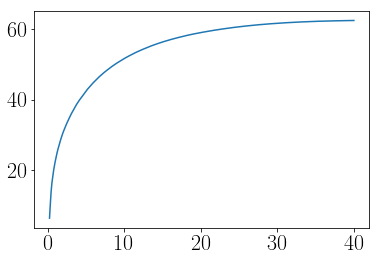

In [608]:
nt = BekD.shape[0]

toff = 12*2 # Starting timestep
Ho = 14 # Pick a starting depth (not necessarily starting at t=0, H=0)

toff = 12
Ho = 5
Ent = 1.0 # Entrainment factor...
H2 = np.zeros((nt, )) 
for i in range(toff, nt):
    H2[i] = H2[i-1]+(2*Ent*-Bek[i]/(N**2))*(time[i]-time[i-1])
    
H = np.sqrt(Ho**2 + H2)
H[0:toff] = np.nan
plt.plot(time/86400, H)

## Calculate the convective layer depth

Note, to do this I need to complete the derivation, and then fit a coefficient to the model runs. Alternately, could directly infer this as the point at which $\langle w' b' \rangle = 0$.

If I assume $v' \sim h/H V^{int}$, then the equation to solve is,

\begin{equation}
 \left(\frac{h}{H} \right)^4 + c^3\frac{B_{Ek}^2}{V^3H}\left(\frac{f}{N^2 \theta}\right)^3\left(1 - \frac{h}{H}\right)^3
\end{equation}

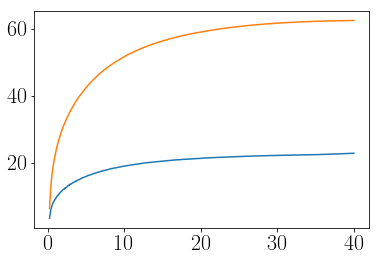

In [609]:
def fithT(ent, H):
    def fithH(factor): #factor is the combined coefficient of the highest order term (ie. Factor*(1-h/h)^3)
        nt = factor.size
        h = np.ones((nt))
        entm = np.mean(ent)
        for i in range(0, nt):
            def f(x):
              return (x-0.35)**2 - 0.1*factor[i]**2*(1-ent[i]*x)

            if np.isfinite(factor[i]):
                h[i], info, ier, n = optimize.fsolve(f, 0.35, maxfev=10000, full_output=True)
                if ier == 0:
                    print('fail')
        return h*H
    return fithH

fact = Lo/H
h = fithT(0*H + 1, H)(fact)
plt.plot(time/86400, h)
plt.plot(time/86400, H)

In [ ]:
# mean coefficient
coef = Bek**2/(H*0.1**3)*(1e-4/(N**2*np.tan(tht[0,0,0])))**3*189**3
print(coef[-1])

In [ ]:
us[-1]**3/(0.4*0.1)**3

In [ ]:
us[-1]**3/(H[-1]*Bek[-1])

In [ ]:
plt.plot(time/86400, h)

## Trajectory in S, Ri space

Calculate the Richardson number and Slope Burger number averaged over the zero PV layer to look at the trajectory in S-Ri space (per Wenegrat et al. 2018).

In [ ]:
#%% Trajectory in S, Ri space

Ri = np.zeros((nt,))
RiB = np.zeros((nt,))
S = np.zeros((nt,))
alpha = np.zeros((nt,))
Sr = np.zeros((nt,))
testr = np.zeros((nt,))
deltabottom = 10

for i in range(0, nt):
    if not (np.isnan(H[i]) or H[i]<2*deltabottom):
        zl = np.where((zm>zm[0]+deltabottom) & (zm<zm[0]+H[i]))[0]
    else: 
        zl = np.where((zm>zm[0]+deltabottom) & (zm<zm[0]+2*deltabottom))[0]
    zd = zm[zl[-1]] - zm[zl[0]]
    uzm = np.mean(uz, axis=1)
    vzm = np.mean(vz, axis=1)
    #wzm = np.mean(wz, axis=1)
    uzm = np.trapz(uzm[i,zl]*np.cos(tht[0,0,0]), x=zm[zl], axis=-1)/zd
    vzm = np.trapz(vzm[i,zl]*np.cos(tht[0,0,0]), x=zm[zl], axis=-1)/zd
    wzm = np.trapz(wz[i,zl]*np.cos(tht[0,0,0]), x=zm[zl], axis=-1)/zd
    sh2  = uzm**2 + vzm**2 + wzm**2
    bzm = np.trapz(bzr[i,zl], x=zm[zl], axis=-1)/zd
    Ri[i] = bzm/sh2
    RiB[i] = bzm*1e-8/(((np.trapz(bz_prime[i,zl], x=zm[zl], axis=-1)/zd)*np.sin(tht[0,0,0]))**2)
    testr[i] = (np.trapz(bz_prime[i,zl], x=zm[zl], axis=-1)/zd)*np.sin(tht[0,0,0])/1e-8
    S[i] = bzm/1e-8*np.tan(tht[0,0,0])**2
    Sr[i] = np.trapz(bz_prime[i,zl], x=zm[zl], axis=-1)/zd/1e-8*np.tanh(tht[0,0,0])**2
    alpha[i] = np.sqrt(S[i]*Ri[i])

In [ ]:
S.shape

In [ ]:
plt.figure()
plt.plot(time/86400, -alpha/Ri, label='$\zeta/f$')
plt.plot(time/86400, -1/Ri, label='$1/Ri$')

plt.plot(time/86400, 1-alpha/Ri-1/Ri, label='q')
plt.legend()
plt.grid()

plt.ylim((-2, 2))
plt.figure()
#plt.plot(Ri, S, linestyle='none', marker='x')
plt.scatter(Ri, S, c=time/86400)
plt.colorbar()
Ria = np.linspace(0, 20, 1000)
Sa = np.linspace(0, 10, 1000)
Rv, Sv = np.meshgrid(Ria, Sa)
plt.contour(Rv, Sv, np.sqrt(Sv*Rv)/Rv + 1/Rv, [0, 1], colors='r')
plt.contour(Rv, Sv, np.sqrt(Sv*Rv)/Rv, [0, 1], colors='g')
plt.grid()
#plt.colorbar()
plt.xlim((0, 5))
plt.ylim((0, 5))

In [ ]:
Rit = np.linspace(0, 10, 1000)
St = np.linspace(0, 3, 1000)
Rv, Sv = np.meshgrid(Rit, St)
alpha = Sv*np.sqrt(Rv)
plt.figure(figsize=(12,8))
PV = Sv*np.sqrt(Rv)/Rv + 1/Rv
maskSI = PV>1
maskBI = np.nan*np.zeros_like(Rv)
maskBI[np.logical_and(PV<=1, alpha<1)] = 1
# maskBI[np.logical_and(PV<=1, 1==1)] = 1

maskBIL = np.nan*np.zeros_like(Rv)
maskBIL[PV<=1] = 1
# maskBI = PV<=1
# maskBI[np.logical_not(maskBI)] = np.nan
cl = 8
plt.contourf(Rv, Sv, maskSI*3, np.linspace(0, cl, 10), cmap='Greys')
plt.contourf(Rv, Sv, maskBI*1, np.linspace(0, cl, 10), cmap='Greys')

# plt.contour(Rv, Sv, (1-Sv**2/(1+Sv**2))*Rv, [0, 1], colors='r')
# plt.contour(Rv, Sv, (Sv/(1+Sv)) + 1/Rv, [1], colors='r')
PVL = plt.contour(Rv, Sv, -1 + Sv*np.sqrt(Rv)/Rv + 1/Rv, [0], colors='g', linewidths=2, linestyles='dashed')
# plt.contour(Rv, Sv, alpha/Rv, [0.2], colors='b', linewidths=2, linestyles='dashed')
CL = plt.contour(Rv, Sv, alpha*maskBIL, [1], colors='b', linewidths=2, linestyles='dashed')
plt.clabel(CL, inline=1, fontsize = 24, fmt='$S\sqrt{Ri}$ $=$ %1.0f', manual=[(7, 0.5)])
plt.clabel(PVL, inline=1, fontsize = 24, fmt='$PV$ $=$ %1.0f', manual = [(7, 2.25)])
plt.yticks([0, 1, 2, 3])

plt.scatter(Ri, np.sqrt(S), c=time/86400)

# plt.contour(Rv, Sv, Sv*np.sqrt(Rv) + 1/Rv, [1], colors='g')

# plt.contour(Rv, Sv, np.sqrt(Sv*Rv)/Rv, [0, 1], colors='g')
# plt.contour(Rv, Sv, np.sqrt(Sv*Rv)/Rv, [0, 1], colors='g')
# plt.grid()
plt.xlabel('Richardson Number $\left[Ri = \\frac{N^2f^2}{|\\nabla b|^2}\\right]$')
plt.ylabel('Slope Burger Number $\left[S = \\frac{N\\theta}{f}\\right]$')
plt.xlim(0,10)
plt.ylim(0, 3)
# plt.annotate('Symmetric/Centrifugal\n instability',
#              xy=(0.5, 2.05), xycoords='data', xytext=(+0, +0), 
#              textcoords='offset points', fontsize=32, ma='center')
# plt.annotate('Baroclinic instability',
#              xy=(2., 0.15), xycoords='data', xytext=(+0, +0), 
#              textcoords='offset points', fontsize=32, ma='center')

## Plot U, N2, and Q as a function of time

In [ ]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

cmin=0
cmax = 2
cminv = 0.03
loff = 20
fig, ax=plt.subplots(3,1, sharex=True, figsize=(14,9))
yl = (zm[0],zm[0]+125)
yl = (z[0], z[0]+100)
#ax[0].plot(time/86400, bflux)
#ax[0].grid()
#plt.colorbar(ax=ax[0])
cminv = -0.1
cmaxv = 0.1
ix = ax[0].contourf(time/86400, z, np.transpose(um[:,:])/0.1,np.linspace(cminv, cmaxv, 26), vmin=cminv, vmax=cmaxv, cmap='seismic', extend='both')
plt.colorbar( ix, ax=ax[0] , ticks=[cminv,0, cmaxv] )
#cb = plt.colorbar( ix, ax=ax[0])

#ax[0].plot(time/86400, bflux)
# ax[0].set_ylabel('$m^2s^{-3}$')
ax[0].set_ylabel('Height above\n bottom (m)')
bb = dict(boxstyle='Square', fc='w')
ax[0].text(0.25,yl[-1]-loff, '$u/V_\infty$', fontsize=20, bbox=bb)
ax[0].grid()
ax[0].set_ylim(yl)

ix = ax[1].contourf(time/86400, z, np.transpose(bz[:,:])/bz[0, 90],np.linspace(cmin, cmax, 26), vmin=cmin, vmax=cmax, cmap='seismic', extend='both')
plt.colorbar( ix, ax=ax[1] , ticks=[cmin,1, cmax] )
#cb = plt.colorbar( ix, ax=ax[0])
# ax[1].plot(time/86400, zm[0] + H)

#ax[0].set_xlabel('Days')
ax[1].set_ylabel('Height above\n bottom (m)')#ax[1].set_title('$N^2/N^2_o$')
ax[1].set_ylim(yl)
ax[1].grid()
ax[1].text(0.24, yl[-1]-loff, '$N^2/N^2_\infty$', fontsize=20, bbox=bb)
#ax[0].plot(time/86400, -Hd)
for c in ix.collections:
    c.set_edgecolor("face")
    
cmin = -15e-9
cmax = 15e-9
cmin = -2
cmax = 2
ix = ax[2].contourf(time/86400, z, np.transpose(qm[:,:])/(1e-4*bz[0,10]), np.linspace(cmin, cmax, 26), vmin=cmin, vmax=cmax, cmap='seismic', extend='both')
plt.colorbar( ix, ax=ax[2] , ticks=[cmin, 0, cmax] )
ax[2].set_xlabel('Days')
ax[2].set_ylabel('Height above\n bottom (m)')
#ax[2].set_title('q')
ax[2].set_ylim(yl)
ax[2].text(0.25, yl[-1]-loff, '$q/(fN^2_\infty)$', fontsize=20, bbox=bb)

# ax[2].plot(time/86400, H, linewidth=2)
# ax[2].plot(time/86400, h, linewidth=2, linestyle='dashed')

#ax[1].plot(time/86400, -H)
#ax[1].plot(time/86400, -hi)
ax[2].grid()
for c in ix.collections:
    c.set_edgecolor("face")
    
# plt.savefig('Overview3_1e-5_0p05.pdf', bbox_inches='tight')

## U, V, N2, and Q

In [ ]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmin=0
cmax = 2
cminv = 0.03
loff = 25
asp = 13
fig, ax=plt.subplots(5,1, sharex=True, figsize=(14,11), gridspec_kw={'height_ratios': [0.5, 1,1, 1, 1]})
yl = (zm[0],zm[0]+125)
yl = (z[0], z[0]+100)
#ax[0].plot(time/86400, bflux)
#ax[0].grid()
#plt.colorbar(ax=ax[0])

ax[0].plot(time/86400, us/0.1, linewidth=3)
ax[0].set_xlim(0, 15)
ax[0].grid()
# ax[0].set_ylabel('m/s')
bb = dict(boxstyle='Square', fc='w')
ax[0].text(0.25,0.008, '$u^*/V_\infty$', fontsize=20, bbox=bb)
# divider = make_axes_locatable(ax[0])
# cax = divider.append_axes("right", size="15%", pad=0.1)


cminv = -0.1
cmaxv = 0.1
ix = ax[1].contourf(time/86400, z, np.transpose(um[:,:])/0.1,np.linspace(cminv, cmaxv, 26), vmin=cminv, vmax=cmaxv, cmap='seismic', extend='both')
plt.colorbar( ix, ax=ax[1] , ticks=[cminv,0, cmaxv] , aspect=asp)
# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes("right", size="15%", pad=0.2)
# plt.colorbar( ix, ax=cax , ticks=[cminv,0, cmaxv] )
plt.colorbar( ix, ax=ax[0] , ticks=[cminv,0, cmaxv] , aspect=asp)
fig.delaxes(fig.axes[6])
#cb = plt.colorbar( ix, ax=ax[0])
cb.visible = False
#ax[0].plot(time/86400, bflux)
# ax[0].set_ylabel('$m^2s^{-3}$')
ax[1].set_ylabel('Height above\n bottom (m)')
bb = dict(boxstyle='Square', fc='w')
ax[1].text(0.25,yl[-1]-loff, '$u/V_\infty$', fontsize=20, bbox=bb)
ax[1].grid()
ax[1].set_ylim(yl)

cminv = 0
cmaxv = 1
ix = ax[2].contourf(time/86400, z, np.transpose(vm[:,:]+0.1)/0.1,np.linspace(cminv, cmaxv, 26), vmin=cminv, vmax=cmaxv, cmap='seismic', extend='both')
plt.colorbar( ix, ax=ax[2] , ticks=[cminv,0, cmaxv] , aspect=asp)
#cb = plt.colorbar( ix, ax=ax[0])

#ax[0].plot(time/86400, bflux)
# ax[0].set_ylabel('$m^2s^{-3}$')
ax[2].set_ylabel('Height above\n bottom (m)')
bb = dict(boxstyle='Square', fc='w')
ax[2].text(0.25,yl[-1]-loff, '$v/V_\infty$', fontsize=20, bbox=bb)
ax[2].grid()
ax[2].set_ylim(yl)
for c in ix.collections:
    c.set_edgecolor("face")


ix = ax[3].contourf(time/86400, z, np.transpose(bz[:,:])/bz[0, 90],np.linspace(cmin, cmax, 26), vmin=cmin, vmax=cmax, cmap='seismic', extend='both')
plt.colorbar( ix, ax=ax[3] , ticks=[cmin,1, cmax] , aspect=asp)
#cb = plt.colorbar( ix, ax=ax[0])
# ax[1].plot(time/86400, zm[0] + H)

#ax[0].set_xlabel('Days')
ax[3].set_ylabel('Height above\n bottom (m)')#ax[1].set_title('$N^2/N^2_o$')
ax[3].set_ylim(yl)
ax[3].grid()
ax[3].text(0.24, yl[-1]-loff, '$N^2/N^2_\infty$', fontsize=20, bbox=bb)
#ax[0].plot(time/86400, -Hd)
for c in ix.collections:
    c.set_edgecolor("face")
    
cmin = -15e-9
cmax = 15e-9
cmin = -2
cmax = 2
ix = ax[4].contourf(time/86400, z, np.transpose(qm[:,:])/(1e-4*bz[0,10]), np.linspace(cmin, cmax, 26), vmin=cmin, vmax=cmax, cmap='seismic', extend='both')
plt.colorbar( ix, ax=ax[4] , ticks=[cmin, 0, cmax], aspect=asp)
ax[4].set_xlabel('Days')
ax[4].set_ylabel('Height above\n bottom (m)')
#ax[2].set_title('q')
ax[4].set_ylim(yl)
ax[4].text(0.25, yl[-1]-loff, '$q/(fN^2_\infty)$', fontsize=20, bbox=bb)

# ax[2].plot(time/86400, H, linewidth=2)
# ax[2].plot(time/86400, h, linewidth=2, linestyle='dashed')

#ax[1].plot(time/86400, -H)
#ax[1].plot(time/86400, -hi)
ax[4].grid()
for c in ix.collections:
    c.set_edgecolor("face")
    
# plt.savefig('Overview3_1e-5_0p02.pdf', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10,10))
ha = 0.1*1e-4/(N**2*tht[0,0,0])
plt.scatter(us/np.max(us), H/ha)
H[-1]/ha

## Plot U, B

In [ ]:
cmin=0
cmax = N**2*np.cos(tht[0,0,0])*100
cmax = 1e-3
cminv = 0.03
loff = 20
fig, ax=plt.subplots(2,1, sharex=True, figsize=(14,6))
yl = (zm[0],zm[0]+125)
yl = (z[0], z[0]+100)
#ax[0].plot(time/86400, bflux)
#ax[0].grid()
#plt.colorbar(ax=ax[0])
cminv = -0.1/10
cmaxv = 0.1/10
ix = ax[0].contourf(time/86400, z, np.transpose(um[:,:]),np.linspace(cminv, cmaxv, 26), vmin=cminv, vmax=cmaxv, cmap='seismic', extend='both')
cb = plt.colorbar( ix, ax=ax[0] , ticks=[cminv,0, cmaxv] )
#cb = plt.colorbar( ix, ax=ax[0])
cb.set_label('$ms^{-1}$')

#ax[0].plot(time/86400, bflux)
# ax[0].set_ylabel('$m^2s^{-3}$')
ax[0].set_ylabel('Height above\n bottom (m)')
bb = dict(boxstyle='Square', fc='w')
ax[0].text(0.25,yl[-1]-loff, 'Cross-slope velocity', fontsize=20, bbox=bb)
ax[0].grid()
ax[0].set_ylim(yl)


# ix = ax[1].contourf(time/86400, z, np.transpose(bz[:,:])/bz[0, 90],np.linspace(cmin, cmax, 26), vmin=cmin, vmax=cmax, cmap='seismic', extend='both')
ix = ax[1].contourf(time/86400, z, np.transpose(bm + N**2*np.cos(tht[0,0,0])*z),np.linspace(cmin, cmax, 26), vmin=cmin, vmax=cmax, cmap='seismic', extend='both')

cb = plt.colorbar( ix, ax=ax[1] , ticks=[cmin,1, cmax] )
cb.set_label('$ms^{-2}$')
#cb = plt.colorbar( ix, ax=ax[0])
ax[1].plot(time/86400, zm[0] + H)

#ax[0].set_xlabel('Days')
ax[1].set_ylabel('Height above\n bottom (m)')#ax[1].set_title('$N^2/N^2_o$')
ax[1].set_ylim(yl)
ax[1].grid()
ax[1].text(0.24, yl[-1]-loff, 'Buoyancy', fontsize=20, bbox=bb)
#ax[0].plot(time/86400, -Hd)
for c in ix.collections:
    c.set_edgecolor("face")
ax[1].set_xlabel('Days')

# plt.savefig('Overview2_1e-5_0p02.eps', bbox_inches='tight')

## Make a cross-frontal slice plot

In [ ]:
ti = -1;
ti = np.where(time/86400>30)[0][0]
ti = -1
cmin = -0.01
cmax = -cmin

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(14, 6), gridspec_kw = {'width_ratios':[4, 1]})
ix = ax[0].contourf(x, zm-zm[0], np.transpose(u[ti,:,:]), np.linspace(cmin, cmax, 20), vmin = cmin, vmax =cmax, extend='both')
for c in ix.collections:
    c.set_edgecolor('face')
cbaxes = inset_axes(ax[0], width="30%", height="6%", loc=1, borderpad=0.5, axes_kwargs={'facecolor':'lightgrey'}) 

cb = plt.colorbar(ix, cax=cbaxes, orientation='horizontal', ticks=[cmin, cmax])
cb.set_label('Cross-slope velocity (m/s)', fontsize=18, color='w')
cbaxes.tick_params(labelcolor='w', labelsize=18)
cb.solids.set_edgecolor("face")

ax[0].contour(x, zm-zm[0], np.transpose(bf[ti,:,:]), 50, colors='k')

ax[0].set_xlabel('x (m)')
ax[0].set_ylim((0, 100))

ti = np.where((time/86400>8) & (time/86400<15))[0]

RGSP = gspr[:,0,:]/N**2*np.gradient(bm[:,:], axis=-1)/np.gradient(z)

# PV FLUX PROFILE using <q'w'> ~ f/H Bek
# ax[1].plot(np.mean(np.mean(wq[ti,:,:], axis=1), axis=0), zm-zm[0], label='wq', linewidth=2)

# ax[1].axvline(np.mean(1e-4*Bek[ti]/H[ti]), color='k')
# ax[1].grid()
# ax[1].set_xlabel('$m^2/s^{3}$')
# ax[1].legend(loc=9)
# ax[1].set_xlim((-1e-14, 1e-14))
# ax[0].set_ylabel('Height above bottom (m)')
# plt.tight_layout();

# ENERGY PROFILES
ax[1].plot(np.mean(np.mean(vbfr[ti,:,:], axis=1), axis=0), zm-zm[0], label='VBP', linewidth=2)
ax[1].plot(-np.mean(np.mean(sp[ti,:,:], axis=1), 0), zm-zm[0], label='SP', linewidth=2)
# ax[1].plot(np.mean(RGSP[ti,:], 0), zm-zm[0], label='SP', linewidth=2)

ax[1].plot(np.mean(np.mean(diss[ti,:,:], axis=1), 0), zm-zm[0], label='DISS', linewidth=2)
# ax[1].plot(np.mean(np.mean(vbfr[ti,:,:,] - sp[ti,:,:], axis=1), 0), zm-zm[0], label='SP', linewidth=2)
# ax[1].plot(np.mean(np.mean(vbfr[ti,:,:,], axis=1)+RGSP[ti,:], 0), zm-zm[0], label='SP', linewidth=2)

ax[1].axvline(np.mean(Beka[ti]), color='k', linestyle='dashed', label='BEBF')
# ax[1].axvline(np.mean(Bek[ti]/Ri[ti]), color='k', linestyle='dashed')
ax[1].grid()
ax[1].set_xlabel('$m^2/s^{3}$ ')
ax[1].legend(loc=9)
ax[1].set_xlim(-1e-8, 1e-8)
ax[0].set_ylabel('Height above bottom (m)')
plt.tight_layout();

# plt.savefig('Slice_1e-5_0p02.eps', bbox_inches='tight')

In [ ]:
plt.plot(time/86400, um[:,6])
plt.xlim(0, 2)

## ENERGY BUDGET

In [ ]:
#%% Pseudo-GSP Profile Only
yl = (-200, -50)
xl = (-0.8e-8, 0.8e-8)
xl2 = (-2e-8, 2e-8)
#yl = (-150, 1)

ti = np.where((time/86400>8) & (time/86400<15))[0]
fix, ax = plt.subplots(1,2, sharey=True,figsize=(10, 7))

#BUOYANCY FLUX TERMS
ax[0].set_title('Days: %1.1f - %1.1f' %( time[ti[0]]/86400 , time[ti[-1]]/86400))


ax[0].plot(np.mean(np.mean(vbfrot[ti,:,:], axis=1), axis=0), zm, label='$\langle w^\prime b^\prime\\rangle$')
#plt.plot(-np.mean(gsp[ti,0,:], 0), zm, label='$GSP$')
#ax[0].plot(-np.mean(np.mean(gsp[ti,:,:], axis=1), 0), zm, label='$GSP$')
#ax[0].plot(-np.mean(np.mean(lsp[ti,:,:], axis=1), 0), zm, label='$LSP$')
ax[0].plot(-np.mean(np.mean(gspr[ti,:,:], axis=1), 0), zm, label='$-f^{-1}N^2\sin\\theta\langle v^\prime w^\prime\\rangle $')
#ax[0].plot(-np.mean(np.mean(gspr[ti,:,:]/(1+N**2/1e-8*np.sin(tht[0,0,0])**2), axis=1), 0), zm, label='$-f^{-1}N^2\sin\\theta\langle v^\prime w^\prime\\rangle $')
BGSP = gspr/(1+N**2/1e-8*np.sin(tht[0,0,0])**2)
#ax[0].plot(-np.mean(np.mean(hbfr[ti,:,:], axis=1), 0), zm, label='$HBf$')
ax[0].axvline(-np.mean(Bek[ti]), linestyle='--', label='$B_{EK}$')
# ax[0].axvline(-np.mean(Beka[ti]), linestyle='--', label='$B_{EKa}$')

#vspt = vspu+vspv 
#plt.plot(-np.mean(vsp[ti,0,:]-gsp[ti,0,:], 0), zm, label='$ASP$')
##plt.plot(-np.mean(np.mean(vsp[ti,:,:], axis=1), 0), zm, label='$VSP$')
#ax[0].plot(np.mean(np.mean(diss[ti,:,:], axis=1), 0), zm, label='DISS')
#ax[1].plot(np.mean(vbfr[ti,0,:]-gsp[ti,0,:]-lsp[ti,0,:]+0*diss[ti,0,:],0), zm, label = 'SUM', linewidth=3)
ax[0].plot(np.mean(vbfrot[ti,0,:]-gspr[ti,0,:]+0*diss[ti,0,:],0), zm, label = 'SUM', linewidth=3)
# ax[0].plot(np.mean(vbfrot[ti,0,:]-BGSP[ti,0,:]+0*diss[ti,0,:],0), zm, label = 'SUM', linewidth=3)

ax[0].axhline(np.nanmean(h[ti]) + zm[0])

#ax[1].plot(np.mean(vbfr[ti,0,:]-sp[ti,0,:]+0*diss[ti,0,:],0), zm, label = 'SUM', linewidth=3)

#plt.plot(np.mean(vbfr[ti,0,:]-vsp[ti,0,:]-lsp[ti,0,:]+diss[ti,0,:],0), zm, label = 'SUM')
#plt.axhline(-100+np.mean(h[ti]))
#plt.plot(np.mean(vbfr[ti,0,:]-vsp[ti,0,:]-lsp[ti,0,:]+diss[ti,0,:],0), zm, label = 'SUM')

#plt.plot(-100*np.mean(EKEt[ti,:], 0), zm, label='EKE$_t$', linestyle='--')

#ax[1].axvline(-np.mean(BekD[ti]), linestyle='--', label='$B_{EK}^D$')
ax[0].set_xlim(xl2)
ax[0].set_ylim(yl)
ax[0].grid()
ax[0].set_xlabel('$m^2/s^{3}$')
ax[0].legend()

test = gspr[:,0,:]/N**2*np.gradient(bm[:,:], axis=-1)/np.gradient(z)
# ENERGETICS
ax[1].plot(np.mean(np.mean(vbfr[ti,:,:], axis=1), axis=0), zm, label='$\langle \widehat{w}^\prime \widehat{b}^\prime\\rangle$', linewidth=2)

ax[1].plot(-np.mean(np.mean(sp[ti,:,:], axis=1), 0), zm, label='$SP$', linewidth=2)
ax[1].plot(np.mean(np.mean(diss[ti,:,:], axis=1), 0), zm, label='DISS', linewidth=2)
ax[1].plot(np.mean(np.mean(-sp[ti,:,:] +vbfr[ti,:,:], axis=1), 0), zm, label='$SUM$', linewidth=2)
ax[1].axhline(np.nanmean(h[ti]) + zm[0])

ax[1].axvline(-np.mean(Beka[ti]), linestyle='--', label='$B_{EK}^D$')
ax[1].set_xlim(xl2)
ax[1].set_ylim(yl)
ax[1].grid()
ax[1].set_xlabel('$m^2/s^{3}$')
ax[1].legend(loc=9)

In [ ]:
# Sanity check to confirm EKE budget is closed
#%% Plot the depth integrated energy budget (constant depth range)
zl = range(0, zm.size)
zl = np.where((zm>zm[0]+0) & (zm<zm[0]+200))[0]

zd = zm[zl[-1]] - zm[zl[0]]

plt.figure(figsize=(10,8))
plt.plot(time/86400, integrate.trapz(EKEt[:,zl], x=zm[zl], axis=-1), label='EKE$_t$') # Rate of change of EKE
plt.plot(time/86400, integrate.trapz(diss[:,0,zl]+vbfr[:,0,zl]-sp[:,0,zl], x=zm[zl], axis=-1), linestyle='dashed', label='SUM')

plt.legend()

In [ ]:
# Sanity check to confirm EKE budget is closed CUMULATIVE
#%% Plot the depth integrated energy budget (constant depth range)
zl = range(0, zm.size)
zl = np.where((zm>zm[0]+0) & (zm<zm[0]+200))[0]

zd = zm[zl[-1]] - zm[zl[0]]

plt.figure(figsize=(10,8))
plt.plot(time/86400, integrate.trapz(EKE[:,0,zl], x=zm[zl], axis=-1), label='EKE$_t$') # Rate of change of EKE
plt.plot(time/86400, integrate.cumtrapz(integrate.trapz(diss[:,0,zl]+vbfr[:,0,zl]-sp[:,0,zl], x=zm[zl], axis=-1), x=time, initial=0), linestyle='dashed', label='SUM')

plt.legend()

In [ ]:
#%% Plot the depth integrated energy budget (constant depth range)
zl = np.where((zm>zm[0]+5) & (zm<zm[0]+200))[0]
zd = zm[zl[-1]] - zm[zl[0]]
Bekfull = np.zeros((EKEt.shape))
Bekfull[:,:] = -Bek[:,np.newaxis]/Ri[:,np.newaxis]*((zm[np.newaxis,:]-zm[0])/(H[:,np.newaxis]) -1 )
Bekfull[Bekfull> 0 ] = 0

Bekfull[:,:] = -Bek[:,np.newaxis]*((zm[np.newaxis,:]-zm[0])/(H[:,np.newaxis]) -1 )/(1+N**2*np.tan(tht[0,0,0])**2/1e-8)
Bekfull[:,:] = -Beka[:,np.newaxis]*((zm[np.newaxis,:]-zm[0])/(H[:,np.newaxis]) -1 )
Bekfull[:,:] = -Beka[:,np.newaxis]*(z/(H[:,np.newaxis]) -1 )

Bekfull[Bekfull> 0 ] = 0


plt.figure(figsize=(10,12))
plt.plot(time/86400, integrate.trapz(EKEt[:,zl], x=zm[zl], axis=-1), label='EKE$_t$') # Rate of change of EKE

plt.plot(time/86400, integrate.trapz(vbfr[:,0, zl],x=zm[zl], axis=-1 ), label='VBF') # True vertical buoyancy flux
plt.plot(time/86400, -integrate.trapz(sp[:,0,zl], x=zm[zl], axis=-1), label = 'SP') # Total shear production

RGSP = gspr[:,0,:]/N**2*np.gradient(bm[:,:], axis=-1)/np.gradient(z)
plt.plot(time/86400, integrate.trapz(RGSP[:,zl], x=zm[zl], axis=-1), 
         label = '$\langle v\prime w\prime \\rangle b_z\\theta$') # Replace the shear production with the RGSP
redgsp = -gspr[:,0,:]*1/(RiB[:,np.newaxis])
redgsp = -gspr[:,0,:]*1/(1+N**2*np.sin(tht[0,0,0])**2/1e-8)

plt.plot(time/86400, integrate.trapz(redgsp[:,zl], x=zm[zl], axis=-1), label = '1/Ri') # Compare with cross-slope mean
#deltav = va[:,zl[-1]] - va[:,zl[0]]
#test = -gspr[:,0,:]*(1 - (deltav[:,np.newaxis]*np.sin(tht[0,0,0])/(1e-4*zd)))
#plt.plot(time/86400, integrate.trapz(test[:,zl], x=zm[zl], axis=-1), label = '$test$')

plt.plot(time/86400, -integrate.trapz(Bekfull[:,zl], x=zm[zl], axis=-1), label = '$Bek$') # Compare with expectation from B_ek
plt.plot(time/86400, -Beka*(H)/2, label = '$Bek$') # Compare with expectation from B_ek

plt.plot(time/86400, integrate.trapz(diss[:,0,zl], x=zm[zl], axis=-1), label = 'DISS')
plt.plot(time/86400, integrate.trapz(diss[:,0,zl]+vbfr[:,0,zl] + redgsp[:,zl], x=zm[zl], axis=-1), linestyle='dashed', label='SUM (TEST)')
plt.plot(time/86400, integrate.trapz(diss[:,0,zl]+vbfr[:,0,zl]-sp[:,0,zl], x=zm[zl], axis=-1), linestyle='dashed', label='SUM')

plt.legend()
#plt.ylim((-1e-6, 1e-6))

In [ ]:
z
# plt.plot(time/86400,1/(1+S))

In [ ]:
# Look at an example vertical profile, averaged over a timerange
ti = np.where((time/86400>10) & (time/86400<15))[0]

# plt.plot(np.mean(-Bekfull[ti,:], axis=0), zm, linestyle='dashed')
plt.plot(np.mean(Bekfull[ti,:], axis=0), zm, linestyle='dashed')

#plt.plot(np.mean(gspr[ti,0,:]*1/(RiB[ti,np.newaxis]), axis=0), zm)
plt.plot(np.mean(RGSP[ti,:], axis=0), zm)
AGSP = -np.mean(sp, axis=1) - RGSP
esi = np.mean(diss, axis=1) - AGSP
# plt.plot(np.mean(AGSP[ti,:], axis=0), zm)
# plt.plot(np.mean(-sp[ti,0,:], axis=0), zm)
plt.plot(np.mean(vbfr[ti,0,:], axis=0), zm)
plt.plot(np.mean(diss[ti,0,:], axis=0), zm)
# plt.plot(np.mean(esi[ti,:], axis=0), zm)

plt.axvline(np.mean(Beka[ti]))
# plt.axvline(np.mean(-Beka[ti]))

# plt.axhline(np.nanmean(h[ti])+zm[0])
# plt.axhline(np.nanmean(H[ti])+zm[0])

plt.xlim((-1e-8, 1e-8))
plt.ylim((zm[0], zm[0] + 100))

In [ ]:
# Look at Buoyancy arrest of shear production
SPI = -integrate.trapz(sp[:,0,zl], x=zm[zl], axis=-1)
plt.plot(time*1e-4, SPI, label = 'SP')

ind = 200
plt.plot(time[ind:]*1e-4,SPI[ind]*exp(-(time[ind:]-time[ind])/tscaleBL))
# plt.plot(time[ind:]*1e-4, -Bek[ind:]*H[ind:]/2/(1+S))

In [ ]:
#Ratio of dissipation to bottom drag
cd = 1.8e-3
S = N**2/1e-8*np.tan(tht[0,0,0])**2
# ub = np.abs(np.sqrt(um[:,zind]**2 + (0.1+vm[:,zind])**2))
ubt = np.sqrt(ub**2 + vb**2)
ubt = np.sqrt(np.sqrt(taux**2 + tauy**2)/(3e-3*1030))
zl = np.where((zm>-200) & (zm<zm[0]+200))[0]

dissvar = diss[:,0,:] + 0*vbfr[:,0,:]
# ub = np.sqrt(np.sqrt(taux**2 + tauy**2)/(1035*2.5e-3))
# bdrag = -1030*cd*np.abs(np.sqrt(np.mean(u[:,:,zind]**2 + (0.1+v[:,:,zind])**2, axis=1)))*(vm[:,zind]+0.1)
bdrag = -1030*cd*ubt**3/1030
bdrag = (ub*taux + vb*tauy)/1035
plt.plot(time/86400, integrate.trapz(dissvar[:,zl], x=zm[zl], axis=-1)/bdrag, label = 'DISS/BDRAG')
# plt.plot(time*1e-4, bdrag)
# plt.plot(time*1e-4, tauy)
# plt.plot(time*1e-4, integrate.trapz(diss[:,0,:], x=zm[:], axis=-1)/Bek/((1+S)*2), label = 'DISS')
plt.plot(time/86400, np.sqrt(S)*N*H/(2*(1+S)*ubt), label='Scaling')
# plt.plot(time/86400, Bek*H/((1+S)*2)/bdrag, label='DissScale/BDRAG')
plt.ylim(0, 10)
plt.axhline(1)
plt.legend()
# Cumulative

startind = 12
plt.figure()
plt.plot(time[startind:]/86400, integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0), label='Bottom Drag')
Bekt = Bek
Bekt[~np.isfinite(Bekt)] = 0
Ht = H
Ht[~np.isfinite(H)] = 0
#plt.plot(time[startind:]/86400, integrate.cumtrapz(Bekt[startind:]*Ht[startind:]/(2*(1+S)), x=time[startind:], initial=0), linestyle='dashed')
plt.plot(time[startind:]/86400, integrate.cumtrapz(integrate.trapz(dissvar[startind:,zl], x=zm[zl], axis=-1), x=time[startind:], initial=0), label='Dissipation')
plt.legend()

## SPECTRAL DOMAIN


In [ ]:
#%% v'w' and w'b'
cmin = -5e-12
cmax = -cmin
cmin = -13
cmax = -10

zl = where((zm>zm[0]+0) & (zm<zm[0]+20) )[0]
IsoSlope = np.arctan2(N**2*tht[0,0,0],(integrate.trapz(bz[:,zl], x=z[zl], axis=-1)/(z[zl[-1]] - z[zl[0]])))
# IsoSlope = np.arctan2((integrate.trapz(bz[:,zl], x=z[zl], axis=-1)/(z[zl[-1]] - z[zl[0]])), - N**2*np.tan(tht[0,0,0]))
#IsoSlope = np.tan(tht[0,0,0])/(N**2*np.tan(tht[0,0,0])**2/1e-8)
LScale = np.abs(H/IsoSlope)
#LScale = np.abs(H/(tht[0,0,0]/(N**2*tht[0,0,0]**2/1e-8)))
fig, ax = plt.subplots(2,1,sharex=True, figsize=(14,6))
ix = ax[0].contourf(time/86400, kx, np.log10(np.abs(np.transpose(integrate.trapz(np.real(kx[np.newaxis,:,np.newaxis]*wvs[:,:,zl]*N**2*tht[0,0,0]/(1e-4)),x=z[zl], axis=-1))/(zm[zl[-1]]-zm[zl[0]]))), 
  np.linspace(cmin, cmax, 20), cmap = 'plasma', vmin=cmin, vmax=cmax, extend='both')
for c in ix.collections:
    c.set_edgecolor('face')
ax[0].set_yscale('log')
ax[0].set_ylim((kx[1], kx[-1]))
ax[0].set_ylabel('$k_x$ (m$^{-1}$)')
ax[0].set_title('$|\widehat{\langle v''w''\\rangle}|$')
ax[0].plot(time/86400, 1/H)
ax[0].plot(time/86400, 1/h)
ax[0].plot(time/86400, 1/LScale)

ix = ax[1].contourf(time/86400, kx, np.log10(np.abs(np.transpose(integrate.trapz(np.real(kx[np.newaxis,:,np.newaxis]*wbs[:,:,zl]), x=z[zl],axis=-1))/(zm[zl[-1]] - zm[zl[0]]))), 
  np.linspace(cmin, cmax, 20), cmap = 'plasma', vmin=cmin, vmax=cmax, extend='both')
for c in ix.collections:
    c.set_edgecolor('face')
ax[1].set_yscale('log')
ax[1].set_ylim((kx[1], kx[-1]))
ax[1].set_xlabel('Days')
ax[1].set_ylabel('$k_x$ (m$^{-1}$)')
ax[1].set_title('$|\widehat{\langle w''b''\\rangle}|$')
ax[1].plot(time/86400, 1/H)
ax[1].plot(time/86400, 1/h)
#ax[1].plot(time/86400, 1/(0.35*H))
ax[1].plot(time/86400, 1/LScale)

cb = fig.colorbar(ix, ax=ax.ravel().tolist(), shrink=0.95)
cb.set_ticks([cmin, cmax])
cb.set_label('$log_{10}(m^2s^{-3})$')

In [ ]:
#%% v'w' and w'b'
cmin = -5e-12
cmax = -cmin
cmin = 1e-13
cmax = 5e-12

nt, nk, nz = wvs.shape
LScale = np.zeros((nt,))
wvsi = np.zeros((nk,nt))
wbsi = np.zeros((nk,nt))

for i in range(0,nt):
    indl = 0
    indu = np.argmin(np.abs(z-H[i]))
    if indu == 0:
        indu = indl+2
    zl = np.arange(indl, indu)
    SlopeI = np.arctan2(N**2*tht[0,0,0],N**2+ (bm[i,indu] - bm[i,indl])/(z[indu]-z[indl]))
    LScale[i] = np.abs(H[i]/SlopeI)
    wvsi[:,i] = np.abs((integrate.trapz(np.real(kx[np.newaxis,:]*wvs[i,:,zl]*N**2*tht[0,0,0]/(1e-4))
                                                    ,x=z[zl], axis=0))/(zm[zl[-1]]-zm[zl[0]]))
    wbsi[:,i] = np.abs((integrate.trapz(np.real(kx[np.newaxis,:]*wbs[i,:,zl])
                                                    ,x=z[zl], axis=0))/(zm[zl[-1]]-zm[zl[0]]))
fig, ax = plt.subplots(2,1,sharex=True, figsize=(14,6))
ix = ax[0].contourf(time/86400, kx, (wvsi),np.linspace(cmin, cmax, 20), cmap = 'plasma', vmin=cmin, vmax=cmax, extend='both')
for c in ix.collections:
    c.set_edgecolor('face')
ax[0].set_yscale('log')
ax[0].set_ylim((kx[1], kx[-1]))
ax[0].set_ylabel('$k_x$ (m$^{-1}$)')
ax[0].set_title(r'$|\widehat{\langle v''w''\\rangle}|N^2_\infty \\theta/f$')
ax[0].plot(time/86400, 1/H)
ax[0].plot(time/86400, 1/h)
ax[0].plot(time/86400, 1/LScale)

ix = ax[1].contourf(time/86400, kx, (wbsi), np.linspace(cmin, cmax, 20), cmap = 'plasma', vmin=cmin, vmax=cmax, extend='both')
for c in ix.collections:
    c.set_edgecolor('face')
ax[1].set_yscale('log')
ax[1].set_ylim((kx[1], kx[-1]))
ax[1].set_xlabel('Days')
ax[1].set_ylabel('$k_x$ (m$^{-1}$)')
ax[1].set_title('$|\widehat{\langle w''b''\\rangle}|$')
ax[1].plot(time/86400, 1/H)
ax[1].plot(time/86400, 1/h)
#ax[1].plot(time/86400, 1/(0.35*H))
ax[1].plot(time/86400, 1/LScale)

cb = fig.colorbar(ix, ax=ax.ravel().tolist(), shrink=0.95)
cb.set_ticks([cmin, cmax])
cb.set_label('$log_{10}(m^2s^{-3})$')

#plt.savefig('SpectralFluxes.jpg', bbox_inches='tight')

In [ ]:
# Divide into high/low wavenumber (nt x nz)
kcut = np.where(kx<1e-2)[0]
kcut = kcut[-1]
gsps = -wvs*N**2*tht/1e-4
vbfs = wbs
gspl = np.sum(gsps[:,1:kcut,:], axis=1)
gsph = np.sum(gsps[:,kcut:,:], axis=1)
vbfl = np.sum(vbfs[:,1:kcut,:], axis=1)
vbfh = np.sum(vbfs[:,kcut:,:], axis=1)

vbfh.shape

In [ ]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

cmin = -2e-9
cmax = -cmin
zl = 75
zoff = 15
cmap = 'Spectral_r'
fig, ax = plt.subplots(4,1,sharex=True, figsize=(14,10))

ax[0].pcolormesh(time/86400, z, np.transpose(vbfl), vmin = cmin, vmax=cmax, cmap=cmap)
ax[0].set_ylabel('z [m]')
ax[0].set_ylim(0, zl)
ax[0].plot(time/86400, H)
ax[0].plot(time/86400, h)
bb = dict(boxstyle='Square', fc='w')
ax[0].text(0.35,zl - zoff, '$VBF_{\lambda > 100m}$', fontsize=20, bbox=bb)

ax[1].pcolormesh(time/86400, z, np.transpose(vbfh), vmin = cmin, vmax=cmax, cmap=cmap)
ax[1].set_ylabel('z [m]')
ax[1].set_ylim(0, zl)
ax[1].plot(time/86400, H)
ax[1].plot(time/86400, h)
ax[1].text(0.35,zl - zoff, '$VBF_{\lambda < 100m}$', fontsize=20, bbox=bb)

ax[2].pcolormesh(time/86400, z, np.transpose(gspl), vmin = cmin, vmax=cmax, cmap=cmap)
ax[2].set_ylabel('z [m]')
ax[2].set_ylim(0, zl)
ax[2].plot(time/86400, H)
ax[2].plot(time/86400, h)
ax[2].text(0.35,zl - zoff, '$GSP_{\lambda > 100m}$', fontsize=20, bbox=bb)

im = ax[3].pcolormesh(time/86400, z, np.transpose(gsph), vmin = cmin, vmax=cmax, cmap=cmap)
ax[3].set_ylabel('z [m]')
ax[3].set_ylim(0, zl)
ax[3].plot(time/86400, H)
ax[3].plot(time/86400, h)
ax[3].set_xlabel('Days')
ax[3].text(0.35,zl - zoff, '$GSP_{\lambda < 100m}$', fontsize=20, bbox=bb)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.925, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label('$m^2/s^{-3}$')

#plt.savefig('SpecByDepth.jpg', bbox_inches='tight')

In [ ]:
ti = 48*26
plt.plot(gspl[ti,:], z)
plt.plot(gsph[ti,:], z)
plt.plot(gspl[ti,:] + gsph[ti,:], z)
plt.axhline(h[ti])

In [ ]:
IsoSlope = np.arctan2(N**2*tht[0,0,0],(integrate.trapz(bz[:,zl], x=z[zl], axis=-1)/(z[zl[-1]] - z[zl[0]])))
IsoSlope = np.arctan2(N**2*tht[0,0,0],N**2+ (bm[:,zl[-1]] - bm[:,zl[0]])/(z[zl[-1]]-z[zl[0]]))
LScale = np.abs(H/IsoSlope)
plt.semilogy(time/86400, 1/LScale)
#plt.plot(time/86400, np.abs(H/(IsoSlope)))
S2 = N**2*tht[0,0,0]**2/1e-8
LscaleE = 0.6*0.1/1e-4*(1+S2)

plt.axhline(1/LscaleE)
plt.plot(time/86400, 1/np.abs(H/(tht[0,0,0]/S2)))
ind = np.where(H>50)[0][0]
plt.axvline(time[ind]/86400)


## Predict H and $\tau$ 

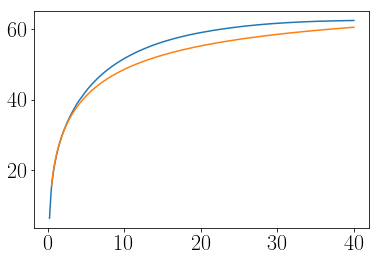

In [612]:
# Compare theory H to H
nt = BekD.shape[0]

toff = 12*2 # Starting timestep
Ho = 14 # Pick a starting depth (not necessarily starting at t=0, H=0)

toff = 24*1
Ho = H[toff]
Ent = 1.0 # Entrainment factor...
cd = 2.e-3
cd = 1.25e-3
Vi = 0.1
H2 = np.zeros((nt, )) 
for i in range(toff, nt):
    #Bektheory = -1035*cd*(Vi - *N**2*tht/(1e-4*(1+N**2*tht**2/1e-8)))**2*N**2*tht/(1e-4)
    #H2[i] = H2[i-1]+(2*Ent*-Bek[i]/(N**2))*(time[i]-time[i-1])
    H2[i] = H2[i-1]+2*cd*tht/1e-4*(Vi - np.sqrt(H2[i-1]+Ho**2)*N**2*tht/(1e-4*(1+N**2*tht**2/1e-8)))**2*(time[i]-time[i-1])
HT = np.sqrt(Ho**2 + H2)
HT[0:toff] = np.nan
plt.plot(time/86400, H)
plt.plot(time/86400, HT)

In [611]:
tht = tht[0,0,0]

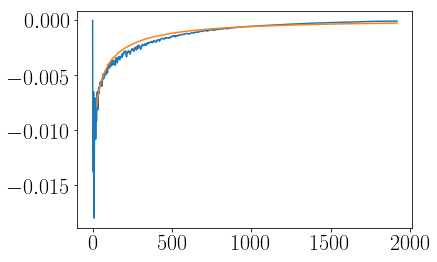

In [613]:
#cd = 2e-3
plt.plot(tauy)
tautheory = -1035*cd*(Vi - HT*N**2*tht/(1e-4*(1+N**2*tht**2/1e-8)))**2
plt.plot(tautheory)



\begin{equation}
u^* = \sqrt{c_d}\left(V_\infty - \frac{HN^2\theta}{f(1+S^2_\infty)}\right)
\end{equation}
\begin{equation}
\sqrt{ c_d} \frac{HN^2\theta}{f(1+S^2_\infty)} = -u^* + \sqrt{ c_d}V_\infty
\end{equation}
let $\gamma^{-1} = \frac{\sqrt{c_d} N^2\theta}{f(1+S^2_\infty)} = \sqrt{c_d}v^g_z$
\begin{equation}
 H = -\gamma\left(u^* - \sqrt{c_d}V_\infty\right)
\end{equation}
\begin{equation}
 H^2 = \gamma^2\left(u^{*2} - 2u^*\sqrt{c_d}V_\infty +  c_d V_\infty^2\right)
\end{equation}
Using 
\begin{equation}
\frac{\partial H^2}{\partial t} = -2\frac{\tau \theta}{\rho f}
\end{equation}
\begin{equation}
\gamma^2 \frac{\partial u^{*2}}{\partial t} - 2\gamma^2\sqrt{c_d}V_\infty\frac{\partial u^*}{\partial t} = -2\frac{u^{*2} \theta}{f}
\end{equation}
\begin{equation}
\frac{\partial u^{*2}}{\partial t} - 2\sqrt{c_d}V_\infty\frac{\partial u^*}{\partial t} = -2u^{*2}\frac{{c_d} N^4\theta^2}{f^2(1+S^2_\infty)^2}\frac{\theta}{f}
\end{equation}
\begin{equation}
\frac{\partial u^{*2}}{\partial t} - 2\sqrt{ c_d}V_\infty\frac{\partial u^*}{\partial t} = -2u^{*2}\frac{{ c_d} S^2_\infty}{(1+S^2_\infty)^2}\frac{N^2\theta}{f}
\end{equation}

Using Wolframalpha this appears to be equivalent to,

\begin{equation}
\frac{\partial u^{*2}}{\partial t}\left( \frac{1}{u^{*2}} - \frac{\sqrt{ c_d}V_\infty}{u^{*3}}\right) = 2\frac{ c_d S^2_\infty}{(1+S^2_\infty)^2}\frac{N^2\theta}{f}
\end{equation}
or,
\begin{equation}
\frac{\partial u^{*2}}{\partial t}\frac{1}{u^{*2}}\left( 1 - \frac{\sqrt{ c_d}V_\infty}{u^{*}}\right) = 2\frac{ c_d S^2_\infty}{(1+S^2_\infty)^2}\frac{N^2\theta}{f}
\end{equation}


ValueError: operands could not be broadcast together with shapes (1919,) (2160,) 

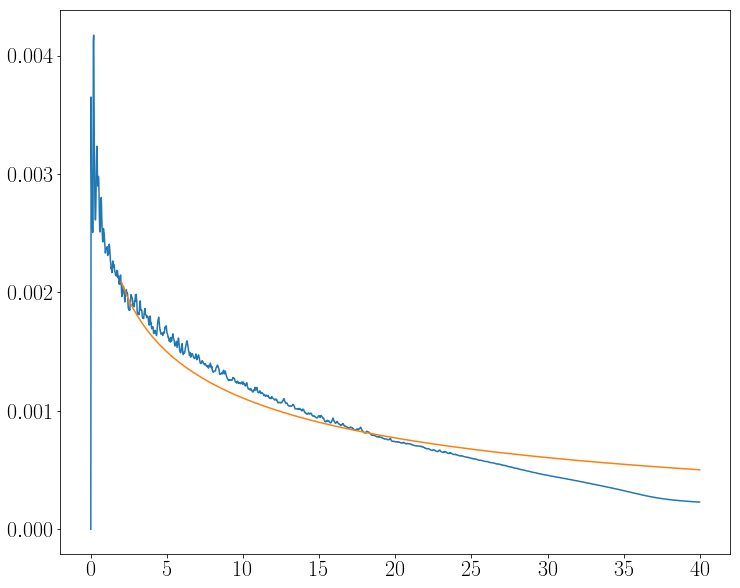

In [614]:
# Compare theory stress  to stress
nt = BekD.shape[0]


toff = 48*2
ustar2o = tauy[toff]/1035
cd = 2e-3
cd = 1.e-3
Vi = 0.1
ustar2 = np.zeros((nt, )) 
S2 = N**2*tht**2/1e-8
ustar2[toff-1] = -ustar2o
ustar2[toff-1] = 0.0033**2
ustartest = np.zeros((nt,))
ustartest[toff-1] = 0.0021
vgz = N**2*tht/(1e-4*(1+S2))
for i in range(toff, nt):
    LHSfactor = 2/ustar2[i-1] - 2*np.sqrt(cd)*Vi/(ustar2[i-1]**(3/2))
    RHSfactor = cd*S2*N**2*tht/((1+S2)**2*1e-4)
    RHSfactor = 2*cd*vgz**2*tht/1e-4
    deltaT = time[i] - time[i-1]
    ustar2[i] = ustar2[i-1]+LHSfactor**(-1)*RHSfactor*deltaT
    LHSfactor = 2/ustartest[i-1] -2*np.sqrt(cd)*Vi/ustartest[i-1]**2
    ustartest[i] = ustartest[i-1]+LHSfactor**(-1)*RHSfactor*deltaT
    #ustar2[i] = ustar2[i-1]+ 2*np.sqrt(cd)*0.1*np.sqrt(ustar2[i-1])-ustar2[i-1]*cd*S2*N**2*tht/(1e-4*(1+S2)**2)*deltaT
ustar2[0:toff] = np.nan
ustartest[0:toff] = np.nan
c1 = 0
a = np.sqrt(cd)*Vi
b = RHSfactor/2
prologarg =a*np.exp(b*time + c1)
ic = (-a/(special.lambertw(prologarg[0])))**(-1)*np.sqrt(ustar2[toff])
ustarsol = -a/(special.lambertw(prologarg))*ic
plt.figure(figsize=(12,10))
plt.plot(time/86400, np.sqrt(-tauy/1035))
#plt.plot(time/86400, np.sqrt(ustar2))
#plt.plot(time/86400, ustarsol)
plt.plot(time/86400, ustartest)
do = np.abs(us)/1e-4
#tauMR91  = 2*H/do/(S2*1e-4)
#tauMR91 = 86400*35
test = ((time[1:]-time[toff])/tauMR91)**(-1/2)
plt.plot(time[1:]/86400, 0.003*(tauMR91/time[1:])**(1/2)/10)
#plt.plot(time/86400, ustar2[toff]*np.exp(-time*RHSfactor))
plt.grid()

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in power
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


0.0

In [481]:
TBL = (1+S2)*(1+S2)/(2*1e-4*0.4**2*cd*N/1e-4*S2**(3/2))
TBL/86400

88.61400462962969

In [467]:
# Note that the Brink and Lentz formulation of the modifier for the BL depth (their equation 22, 23) is the same 
Rib = (1+S2) # This is the critical Ri number for PV = 0 (with v_x < 0)
(1+(1+4*Rib*S2)**(1/2))/2 # Brink and Lentz Gamma function

(1+S2) # Comes directly from assuming that PV = 0

1.3999999999999997

In [456]:
tht = tht[0,0,0]

## EXTRAS

Notice that the equation for the PV=0 layer depth gives,
\begin{equation}
\frac{\partial H^2}{\partial t} = - \frac{\tau^y\theta}{\rho}
\end{equation}
This can then be rearranged to give an equation for the stress in terms of the BBL height. 

Noting that the depth integrated SI dissipation is,
\begin{equation}
\int_0^H \epsilon \approx \frac{H}{2}EBF_s
\end{equation}
allows the depth integrated dissipation to be written as,

\begin{equation}
\int_0^H \epsilon \approx \frac{1}{6}\frac{\partial H^3}{\partial t}\frac{N^2}{1+S^2_\infty}
\end{equation}

This can then be integrated in time until the arrested Ekman depth is achieved, $H_a = V_\infty f (1+S^2_\infty)/N^2\theta$. Giving the total dissipation during arrest as,

\begin{equation}
\int_0^\infty \int_0^H \epsilon\;dz dt \approx \frac{1}{6}H_a^3\frac{N^2}{1+S^2_\infty}
\end{equation}

\begin{equation}
\int_0^\infty \int_0^H \epsilon\;dz dt \approx \frac{1}{6}\frac{V_i^3f^3(1+S^2_\infty)^3}{N^6\theta^3}\frac{N^2}{1+S^2_\infty}
\end{equation}

\begin{equation}
\int_0^\infty \int_0^H \epsilon\;dz dt \approx \frac{1}{6}\frac{V_i^3(1+S^2_\infty)^2}{N_\infty S_\infty^3}
\end{equation}

In [637]:
DISS = f['tasks']['Diss'][:,0,:]
DISS.shape

DISSi = integrate.trapz(DISS, axis=-1, x=z)
DISSti = integrate.cumtrapz(DISSi, x=time, initial=0)
DISSti.shape

# calculate mean flow dissipation
uzm = np.gradient(um, axis=-1)/np.gradient(z)
vzm = np.gradient(vm, axis=-1)/np.gradient(z)
wzm = np.gradient(np.mean(w, axis=1), axis=-1)/np.gradient(z)
vgzm = -np.gradient(bm, axis=-1)/np.gradient(z)*tht/1e-4
MDISS = 1e-4*(uzm**2 + vzm**2 + wzm**2)

MDISSi = integrate.trapz(MDISS, axis=-1, x=z)
MDISSti = integrate.cumtrapz(MDISSi, x=time, initial=0)

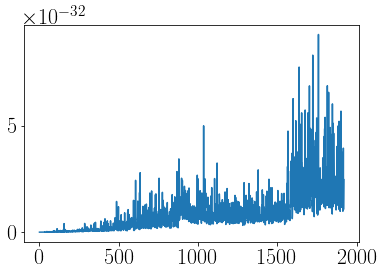

In [636]:
plt.plot(integrate.trapz(wzm**2, axis=-1, x=z))

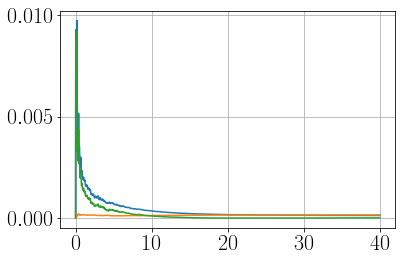

In [616]:
plt.plot(time/86400, integrate.trapz(vzm**2, x=z, axis=-1))
plt.plot(time/86400, integrate.trapz(vgzm**2, x=z, axis=-1))
plt.plot(time/86400, integrate.trapz((vzm-vgzm)**2, x=z, axis=-1))

#plt.plot(time/86400, 200*((0.1)**2/(H+1)**2))
#plt.plot(time/86400, (200/(H+1)*(N**2*tht/(1e-4*(1+S2))))**2 + 0*H)
#plt.ylim(0,1e-2)
plt.grid()

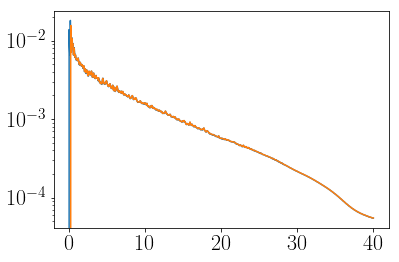

In [628]:
plt.semilogy(time/86400, -tauy)
plt.plot(time/86400, 1035*1e-4/(2*tht)*np.gradient(H**2)/np.gradient(time))


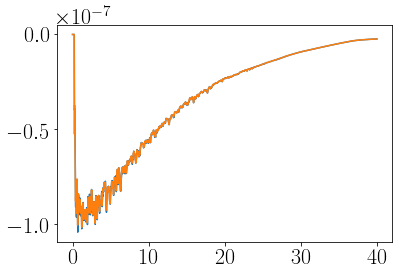

In [627]:
S2= N**2*tht**2/1e-8
plt.plot(time/86400, Beka*H/2)
plt.plot(time/86400, -1/2*1/3*1e-4/(tht)*np.gradient(H**3)/np.gradient(time) * N**2*tht/(1e-4*(1+S2)))

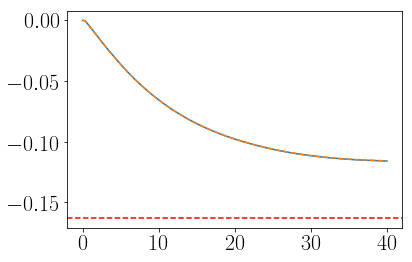

In [626]:
Htemp = H
Htemp[np.isnan(H)] = 0
plt.plot(time/86400, integrate.cumtrapz(Beka*Htemp/2, x=time, initial=0))
dissscale = -1/2*1/3*1e-4/(tht)*np.gradient(Htemp**3)/np.gradient(time) * N**2*tht/(1e-4*(1+S2))
plt.plot(time/86400, integrate.cumtrapz(dissscale, x=time, initial=0), linestyle='--')
Vi = 0.1
harrest = Vi/(N**2*tht/(1e-4*(1+S2)))
#dissscalemax = -1/2*1/3*1e-4/(tht)*harrest**3 * N**2*tht/(1e-4*(1+S2))
#dissscalemax = -1/6*harrest**3 *N**2/(1+S2)
#plt.axhline(dissscalemax)
dissscalemax = -1/6*Vi**3*(1+S2)**2/(N*S2**(3/2))
plt.axhline(dissscalemax, color='r', linestyle='--')
Ti = 2*np.pi/1e-4
#plt.axhline(-10*Ti*Vi**3/1035) # Trying the Umlauf et al. 2015 formulation

Ratio of bottom drag on interior flow to SI dissipation

Bottom drag goes as $V_i \tau^y$. SI dissipation goes as $\frac{1}{6}\frac{\partial H^3}{\partial t}\frac{N^2}{1+S^2_\infty}$. 

Using the rate of change of H, the bottom drag can be written as ,
\begin{equation}
DRAG = V_i \frac{f}{2\theta}\frac{\partial H^2}{\partial t}.
\end{equation}

So the time integrated drag is,
\begin{equation}
\int_o^T DRAG = V_i \frac{f}{2\theta}H^2(T).
\end{equation}
and the time integrated SI dissipation is,
\begin{equation}
DISS_{SI} = \frac{1}{6}H^3(T)\frac{N^2}{1+S^2_\infty}
\end{equation}
Hence the ratio of the two is,
\begin{equation}
\frac{DISS_{SI}}{DRAG} = \frac{1}{3}\frac{H(T) N^2 \theta}{V_i f(1+S^2_\infty)}
\end{equation}
Note that this is $(1/3)V^g/V_i$, such that if $T=T_E$ the ratio is $1/3$.

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Q ratio: 0.5
Q ratio no SI: 2.1


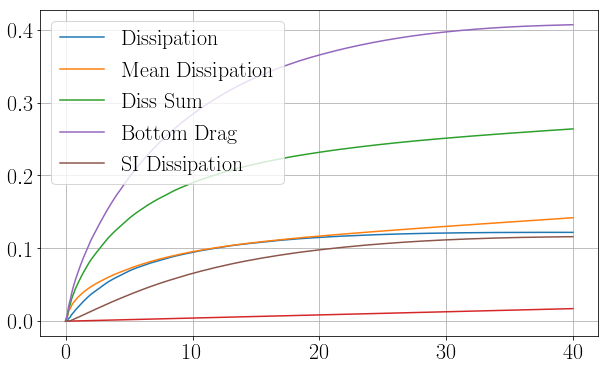

In [638]:
plt.figure(figsize=(10,6))
plt.plot(time/86400, -DISSti, label='Dissipation')
plt.plot(time/86400, MDISSti, label='Mean Dissipation')
plt.plot(time/86400, MDISSti-DISSti, label='Diss Sum')
plt.plot(time/86400, integrate.cumtrapz(200*1e-4*(0.1/(200+0*H))**2, x=time, initial=0))
BDRAG = integrate.cumtrapz(-0.1*tauy/1035, x=time, initial=0)
plt.plot(time/86400, BDRAG, label='Bottom Drag')
plt.plot(time/86400, 1/6*H**3*N**2/(1+N**2*tht**2/1e-8), label='SI Dissipation')

plt.grid()
plt.legend()

#Q efficiency is bottom drag minus total dissipation over total dissipation
ts = np.argmin(np.abs(time/86400 - 14))
print('Q ratio: %1.1f'%((BDRAG - (MDISSti-DISSti))/(MDISSti-DISSti))[ts])
print('Q ratio no SI: %1.1f'%((BDRAG - (MDISSti))/(MDISSti))[ts])

In [620]:
H[-1]*N**2*tht/(1e-4*(1+S2))

0.08921166232506178

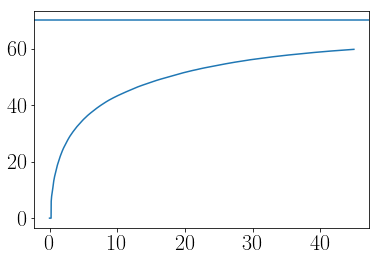

In [474]:
plt.plot(time/86400, H)
plt.axhline(harrest)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0,0.5,'N/f')

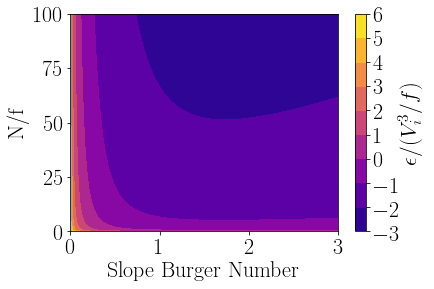

In [469]:
# Consider parameter space

Ssq = np.linspace(0, 3, 200)
Nif = np.linspace(1e-1, 100, 250)

plt.contourf(Ssq, Nif, np.transpose(np.log10(1/6*(1+Ssq[:,np.newaxis]**2)**2/(Nif[np.newaxis,:]*Ssq[:,np.newaxis]**3))), cmap='plasma')#normalized by Vi^3
cb = plt.colorbar()
cb.set_label('$\epsilon/(V_i^3/f)$')
plt.xlabel('Slope Burger Number')
plt.ylabel('N/f')


Text(0.5,0,'$S_\\infty$')

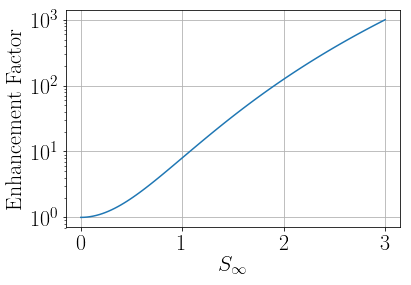

In [507]:
# Increasing the stratification by a factor of (1+S2) in the boundary layer makes H_a bigger by the same, hence increases
# integrated dissipation by factor of (1+S2)**3
Ssq = np.linspace(0, 3, 100)
plt.semilogy(Ssq, (1+Ssq**2)**3)
plt.grid()
plt.ylabel('Enhancement Factor')
plt.xlabel('$S_\infty$')

In [ ]:
DISSB = f['tasks']['DISSBPRIME']
DISSBPARTIAL = -f['tasks']['DISSBPARTIAL']/N**2

# Eddy buoyancy budget terms
bp = b - bm[:,np.newaxis,:]
bpx = np.gradient(bp, axis=1)/np.gradient(x[np.newaxis,:,np.newaxis], axis=1)
bpz = np.gradient(bp, axis=-1)/np.gradient(z)
MIX = -1e-4/N**2*np.mean(bpx**2 + bpz**2, axis=1)

In [ ]:
np.abs(LScale)

In [ ]:
plt.plot(integrate.cumtrapz(integrate.trapz(DISSB[:,0,:], x=z, axis=-1), x=time))
plt.plot(integrate.cumtrapz(integrate.trapz(DISSBPARTIAL[:,0,:], x=z, axis=-1), x=time))

plt.plot(integrate.cumtrapz(integrate.trapz(MIX[:,:], x=z, axis=-1), x=time))

In [ ]:
plt.plot(testr*1e-8/np.sin(tht[0,0,0])/N**2)

In [ ]:
plt.plot(time/86400, 1/Ri)
plt.plot(time/86400, 1/RiB)
plt.plot(time/86400, 1-alpha/RiB)
plt.plot(time/86400, (-1 + 0.1*np.sin(tht[0,0,0])/(1e-4*H)))
#plt.plot(time/86400,N**2*tht[0,0,0]*H/(1e-4*0.1))
#plt.ylim((0, 1))

In [ ]:
plt.plot(time/86400, Ri, label='$\zeta/f$')
plt.legend()
plt.ylim(0, 1)

In [ ]:
gspr.shape

In [ ]:
RiB

In [ ]:
plt.plot(np.mean(v[-1,:,:], axis=0), zm)
plt.axvline(0.1/100)
plt.axvline(np.mean(vz[-1,:,:]), color='r')
plt.axhline(zm[0]+H[-1])

In [ ]:
# Ruan bottom stress formulation (with Brink and Lentz adjustment)

#tb = 1030*1e-3*(0.1 - 2/(1+np.sqrt(1+4*Ri*N**2/1e-8*tht[0,0,0]**2))*tht[0,0,0]*N**2*H/1e-4)**2
tb = 1030*1e-3*(0.1 - 1.5/(1+np.sqrt(1+4*Ri*N**2/1e-8*tht[0,0,0]**2))*tht[0,0,0]*N**2*H/1e-4)**2

tscale = 1/((N**2*tht[0,0,0]**2/1e-8)**2*1e-4*np.cos(tht[0,0,0]))
plt.figure(figsize=(10,10))
plt.plot(time/86400, tauy)
plt.plot(time/86400, -tb)
plt.plot(time/86400, -1030*1e-3*0.1**2*((time/tscale)**(-1/2)))

In [ ]:
1e-5*np.tanh(0.0225)**2/1e-8

In [ ]:
(14**3*1e-4/(N**2*tht[0,0,0])*tauy[-1]**2/(1030**2 * 0.1**3*H[-1]))**(1/4)